# CNN-GRU

```zsh
pipenv --python 3.11
pipenv install ipykernel==6.28.0 python-dotenv==1.0.0 torch torchvision torchinfo
```

## Imports

In [2]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torchinfo import summary
import os
import numpy as np
import json
import glob
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
from datetime import datetime
import torch.onnx

## Load Dataset

In [3]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Get a list of all txt files in ./data-gen/data/ and its subdirectories
txt_files = glob.glob('../data-gen/data/**/*.txt', recursive=True)

for txt_file in txt_files:
    # Open the txt file and load the data
    with open(txt_file, 'r') as f:
        data = json.load(f)
    
    # Transform the data
    transformed_data = []
    for array in data:
        transformed_array = []
        for obj in array:
            transformed_array.append([obj['x'], obj['y'], obj['z']])
        transformed_data.append(transformed_array)
    
    # print(txt_file)
    # print(np.array(transformed_data).shape)

    # Create the new json file path
    json_file = os.path.splitext(txt_file)[0] + '.json'

    # Write the transformed data to the new json file
    with open(json_file, 'w') as f:
        json.dump(transformed_data, f)

In [4]:
# Assuming 'data' is your root directory containing all the data folders
root_dir = '../data-gen/data/'
total_samples = 0

# Iterate over all folders in the root directory
for folder_name in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder_name)
    
    # Check if the path is indeed a folder
    if os.path.isdir(folder_path):
        # Count the number of files in the folder
        num_files = len(os.listdir(folder_path))
        total_samples += num_files

print(f"Total number of samples: {total_samples}")

Total number of samples: 420


(60, 21, 3) ==> (1260, 3) ==> (3, 1260)

In [6]:
batch_size=35

class LandmarkDataset(Dataset):
    def __init__(self, files, labels):
        self.files = files
        self.encoder = LabelEncoder()
        self.labels = self.encoder.fit_transform(labels)

    def get_original_labels(self, encoded_labels):
        return self.encoder.inverse_transform(encoded_labels)
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        with open(self.files[idx], 'r') as f:
            data_list = json.load(f)
            for i, frame in enumerate(data_list):
                if len(frame) != 21:  # Check if each frame has 21 landmarks
                    print(f"Unexpected frame length in file {self.files[idx]} at frame {i}: {len(frame)}")
            data = torch.tensor(data_list)
            data = data.view(-1, 3)  # Flatten the data into (1260, 3)
            data = data.transpose(0, 1)  # Transpose to get (3, 1260)
        label = torch.tensor(self.labels[idx])
        return data, label

# Get a list of all json files in ../data-gen/data/ and its subdirectories
json_files = glob.glob('../data-gen/data/**/*.json', recursive=True)

# Get labels (parent folder names) for each json file
labels = [os.path.basename(os.path.dirname(file)) for file in json_files]

# Split data into train and test sets
train_files, val_files, train_labels, val_labels = train_test_split(json_files, labels, test_size=0.2, random_state=42)

# Create train and test datasets
train_dataset = LandmarkDataset(train_files, train_labels)
val_dataset = LandmarkDataset(val_files, val_labels)

# Create train and test loaders
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

In [7]:
# get one batch of data
count = 0
for data, labels in train_loader:
    print(data.shape)
    print(labels.shape)
    count += 1
    print(count)


torch.Size([35, 3, 1260])
torch.Size([35])
1
torch.Size([35, 3, 1260])
torch.Size([35])
2
torch.Size([35, 3, 1260])
torch.Size([35])
3
torch.Size([35, 3, 1260])
torch.Size([35])
4
torch.Size([35, 3, 1260])
torch.Size([35])
5
torch.Size([35, 3, 1260])
torch.Size([35])
6
torch.Size([35, 3, 1260])
torch.Size([35])
7
torch.Size([35, 3, 1260])
torch.Size([35])
8


In [8]:
for data, labels in train_loader:
  print(data[0][0].shape)
  print(labels[0].item())
  # Get original labels
  original_labels = train_dataset.encoder.inverse_transform(labels)
  print(original_labels)

torch.Size([1260])
5
['n' 'z' 'm' 'c' 'm' 'j' 'i' 'm' 'i' 'i' 'c' 'z' 'z' 'z' 'c' 'i' 'm' 'n'
 'z' 'j' 'c' 'c' 'g' 'g' 'g' 'i' 'c' 'g' 'g' 'm' 'z' 'z' 'g' 'n' 'm']
torch.Size([1260])
1
['g' 'i' 'm' 'g' 'c' 'n' 'n' 'z' 'i' 'c' 'z' 'i' 'z' 'n' 'n' 'c' 'j' 'i'
 'n' 'n' 'i' 'z' 'n' 'n' 'z' 'm' 'n' 'm' 'j' 'c' 'g' 'n' 'j' 'i' 'j']
torch.Size([1260])
1
['g' 'n' 'j' 'c' 'i' 'n' 'i' 'g' 'n' 'm' 'c' 'i' 'i' 'c' 'g' 'n' 'm' 'z'
 'm' 'n' 'j' 'j' 'm' 'z' 'g' 'g' 'j' 'i' 'j' 'n' 'n' 'm' 'z' 'i' 'c']
torch.Size([1260])
1
['g' 'z' 'c' 'm' 'z' 'm' 'j' 'g' 'j' 'c' 'g' 'n' 'g' 'j' 'g' 'n' 'c' 'i'
 'm' 'z' 'c' 'j' 'c' 'm' 'i' 'n' 'm' 'm' 'c' 'm' 'g' 'n' 'g' 'c' 'c']
torch.Size([1260])
5
['n' 'j' 'i' 'g' 'c' 'j' 'g' 'z' 'm' 'c' 'c' 'n' 'j' 'g' 'g' 'g' 'g' 'g'
 'z' 'g' 'z' 'i' 'i' 'z' 'm' 'j' 'i' 'j' 'i' 'i' 'm' 'n' 'g' 'j' 'n']
torch.Size([1260])
0
['c' 'm' 'm' 'g' 'm' 'j' 'z' 'i' 'j' 'z' 'i' 'm' 'j' 'j' 'g' 'n' 'i' 'c'
 'n' 'n' 'i' 'z' 'c' 'n' 'z' 'j' 'g' 'm' 'j' 'j' 'z' 'n' 'i' 'j' 'i']
torch.Size([1260

## Model Set Up

```txt
Model
├── Input Layer
│   └── Conv1D
│       └── MaxPooling1D
│           └── Flatten
│               └── Dense
│                   ├── Concatenate (Final Layer)
│                   └── Reshape
│                       └── GRU
│                           └── GRU_1
│                               └── Dense_1
│                                   └── Concatenate (Final Layer)
``` 
PyTorch's Conv1D layer expects input in the form (batch_size, num_channels, length). In your case, you can consider each coordinate as a channel. So, your input to the Conv1D layer would be (batch_size, 3, 1260), where 1260 is the product of 60 (frames) and 21 (landmarks).

(60, 21, 3) ==> (1260, 3) ==> (3, 1260) ==> (batch_size, 3, 1260)

In PyTorch, it's common to leave out the softmax activation function in the model and instead use the nn.CrossEntropyLoss loss function during training, which applies the softmax function internally. Then, when making predictions, you can apply the softmax function to the model's outputs to get probabilities.

In [35]:
class CNN_GRU_Model(nn.Module):
    def __init__(self):
        super(CNN_GRU_Model, self).__init__()
        self.conv1d = nn.Conv1d(3, 64, kernel_size=3)
        self.maxpooling1d = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(40256, 64)  # Adjust this based on the output of the previous layer
        self.gru = nn.GRU(64, 100, batch_first=True)
        self.gru_1 = nn.GRU(100, 100, batch_first=True)
        self.dense_1 = nn.Linear(100, 64)
        self.final_dense = nn.Linear(128, 7)  # Final Dense layer for 7 classes

    def forward(self, x):
        x = self.conv1d(x)
        x = self.maxpooling1d(x)
        x = self.flatten(x)
        dense_output = self.dense(x)
        x = dense_output.view(dense_output.shape[0], 1, -1)
        x, _ = self.gru(x)
        x, _ = self.gru_1(x)
        x = self.dense_1(x[:, -1, :])
        x = torch.cat((dense_output, x), dim=1)
        x = self.final_dense(x)
        return x

# Instantiate the model
model = CNN_GRU_Model().to(device)

# Print model summary
print(summary(model, input_size=(64, 3, 1260)))


Layer (type:depth-idx)                   Output Shape              Param #
CNN_GRU_Model                            [64, 7]                   --
├─Conv1d: 1-1                            [64, 64, 1258]            640
├─MaxPool1d: 1-2                         [64, 64, 629]             --
├─Flatten: 1-3                           [64, 40256]               --
├─Linear: 1-4                            [64, 64]                  2,576,448
├─GRU: 1-5                               [64, 1, 100]              49,800
├─GRU: 1-6                               [64, 1, 100]              60,600
├─Linear: 1-7                            [64, 64]                  6,464
├─Linear: 1-8                            [64, 7]                   903
Total params: 2,694,855
Trainable params: 2,694,855
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 223.96
Input size (MB): 0.97
Forward/backward pass size (MB): 41.39
Params size (MB): 10.78
Estimated Total Size (MB): 53.14


## Training

In [28]:
wandb.login()

True

In [29]:
def calculate_accuracy(loader):
    correct = 0
    total = 0
    # Set model to evaluation mode
    model.eval()
    # Disable gradient calculation (unnecessary for inference)
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [36]:
now = datetime.now()  # current date and time
run_time = now.strftime("%Y-%m-%d_%H-%M-%S")
run = wandb.init(project="sign_language", name=f"CNN-GRU_{run_time}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 40

train_accuracies = []
val_accuracies = []
losses = []

for epoch in range(num_epochs):
    # Set model to training mode
    model.train()

    # Iterate over data
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        
        # Log loss to WandB
        wandb.log({"train_loss": loss.item()})

    train_accuracy = calculate_accuracy(train_loader)
    train_accuracies.append(train_accuracy)
    
    # Log train accuracy to WandB
    wandb.log({"train_accuracy": train_accuracy})

    # Evaluate on validation set
    val_accuracy = calculate_accuracy(val_loader)
    val_accuracies.append(val_accuracy)
    
    # Log validation accuracy to WandB
    wandb.log({"val_accuracy": val_accuracy})
    
    print(f"Epoch {epoch+1}/{num_epochs}, Validation accuracy: {val_accuracy}%")

# Optionally, log final metrics after training completes
wandb.log({"final_train_accuracy": train_accuracies[-1], "final_val_accuracy": val_accuracies[-1]})


Epoch 1/40, Validation accuracy: 15.714285714285714%
Epoch 2/40, Validation accuracy: 30.0%
Epoch 3/40, Validation accuracy: 42.857142857142854%
Epoch 4/40, Validation accuracy: 51.42857142857143%
Epoch 5/40, Validation accuracy: 67.14285714285714%
Epoch 6/40, Validation accuracy: 75.71428571428571%
Epoch 7/40, Validation accuracy: 81.42857142857143%
Epoch 8/40, Validation accuracy: 85.71428571428571%
Epoch 9/40, Validation accuracy: 84.28571428571429%
Epoch 10/40, Validation accuracy: 84.28571428571429%
Epoch 11/40, Validation accuracy: 90.0%
Epoch 12/40, Validation accuracy: 90.0%
Epoch 13/40, Validation accuracy: 90.0%
Epoch 14/40, Validation accuracy: 87.14285714285714%
Epoch 15/40, Validation accuracy: 94.28571428571429%
Epoch 16/40, Validation accuracy: 94.28571428571429%
Epoch 17/40, Validation accuracy: 94.28571428571429%
Epoch 18/40, Validation accuracy: 92.85714285714286%
Epoch 19/40, Validation accuracy: 91.42857142857143%
Epoch 20/40, Validation accuracy: 94.28571428571429%

In [13]:
total_train_accuracies = []
total_val_accuracies = []
total_losses = []

In [14]:
total_train_accuracies += train_accuracies
total_val_accuracies += val_accuracies
total_losses += losses

In [15]:
print(len(total_train_accuracies))
print(len(total_val_accuracies))
print(len(total_losses))
print(len(range(1, len(total_losses) + 1)))

40
40
320
320


## Evaluation

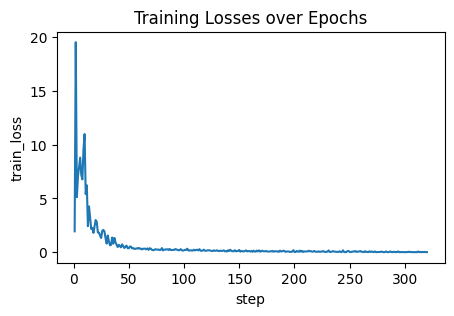

In [16]:
# Create a dataframe
df_loss = pd.DataFrame({
    'step': range(1, len(total_losses) + 1),
    'train_loss': total_losses,
})

# Create lineplot for losses
plt.figure(figsize=(5, 3))
sns.lineplot(data=df_loss, x='step', y='train_loss')
plt.title('Training Losses over Epochs')
plt.show()

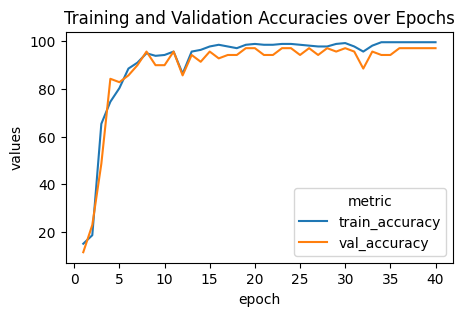

In [17]:
# Create a dataframe
df_acc = pd.DataFrame({
    'epoch': range(1, len(total_train_accuracies) + 1),
    'train_accuracy': total_train_accuracies,
    'val_accuracy': total_val_accuracies
})

# Melt dataframe to long-form for easier plotting
df_acc_melted = df_acc.melt('epoch', var_name='metric', value_name='values')

# Create lineplot for accuracies
plt.figure(figsize=(5, 3))
sns.lineplot(data=df_acc_melted, x='epoch', y='values', hue='metric')
plt.title('Training and Validation Accuracies over Epochs')
plt.show()

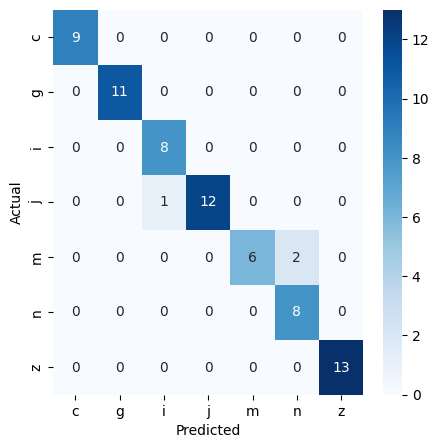

In [31]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Get actual labels
actual_labels = train_dataset.get_original_labels(range(len(train_dataset.encoder.classes_)))

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=actual_labels, yticklabels=actual_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

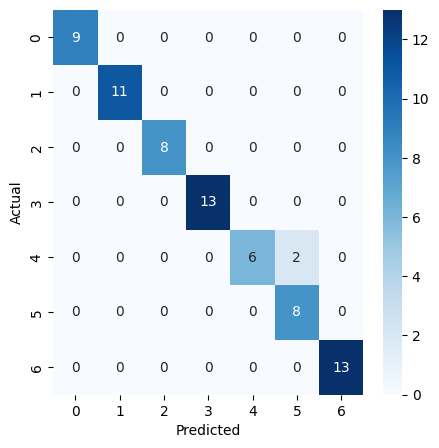

In [24]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [47]:
torch.save(model, 'model.pth')

In [37]:
wandb.save("model.pth")
run.finish()

final_train_accuracy,▁
final_val_accuracy,▁
train_accuracy,▁▃▃▄▅▆▇▇▇▇▇██▇████████████████████▇█████
train_loss,█▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▄▅▆▇▇▇▇▇▇▇▇█████████▇█████▇███▇▇█████
final_train_accuracy,98.57143
final_val_accuracy,97.14286
train_accuracy,98.57143
train_loss,0.01319
val_accuracy,97.14286


## Convert model to Other format

### ONNX

In [46]:
# Create a dummy input with appropriate data type
dummy_input = torch.randn(64, 3, 1260, device=device, dtype=torch.float32)

# Specify the file path where you want to save the ONNX model
onnx_file_path = "model.onnx"

# Export the model to ONNX format
torch.onnx.export(
    model,                     # model being run
    dummy_input,               # model input (or a tuple for multiple inputs)
    onnx_file_path,            # where to save the model (can be a file or file-like object)
    export_params=True,        # store the trained parameter weights inside the model file
    opset_version=10,          # the ONNX version to export the model to
    do_constant_folding=True,  # whether to execute constant folding for optimization
    input_names=['input'],     # the model's input names
    output_names=['output'],   # the model's output names
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}  # variable length axes
)


print(f"Model has been saved to {onnx_file_path}")


Model has been saved to model.onnx


In [45]:
import onnx
from onnx import helper, numpy_helper
import numpy as np

# Load the ONNX model
onnx_model = onnx.load(onnx_file_path)

# Check and convert int64 tensors to int32
def convert_int64_to_int32(model):
    for initializer in model.graph.initializer:
        if initializer.data_type == onnx.TensorProto.INT64:
            int64_data = numpy_helper.to_array(initializer)
            int32_data = int64_data.astype(np.int32)
            new_initializer = numpy_helper.from_array(int32_data, initializer.name)
            model.graph.initializer.remove(initializer)
            model.graph.initializer.append(new_initializer)

    for node in model.graph.node:
        for attr in node.attribute:
            if attr.type == onnx.AttributeProto.TENSOR and attr.t.data_type == onnx.TensorProto.INT64:
                int64_data = numpy_helper.to_array(attr.t)
                int32_data = int64_data.astype(np.int32)
                new_tensor = numpy_helper.from_array(int32_data)
                new_tensor.name = attr.t.name
                attr.t.CopyFrom(new_tensor)

    return model

# Convert and save the modified model
onnx_model = convert_int64_to_int32(onnx_model)
onnx.save(onnx_model, onnx_file_path)

# Verify the ONNX model for int64 tensors
def check_for_int64(model):
    for tensor in model.graph.initializer:
        if tensor.data_type == onnx.TensorProto.INT64:
            print(f"Found int64 tensor in initializer {tensor.name}")
            return True
    for node in model.graph.node:
        for attr in node.attribute:
            if attr.type == onnx.AttributeProto.TENSOR and attr.t.data_type == onnx.TensorProto.INT64:
                print(f"Found int64 tensor in node {node.name}")
                return True
    return False

if check_for_int64(onnx_model):
    print("Model contains int64 tensors. Modify the model to use int32 tensors.")
else:
    print("Model does not contain int64 tensors.")



Model does not contain int64 tensors.


### TorchScript

In [48]:
scripted_model = torch.jit.script(model)  # Convert to TorchScript
scripted_model.save('model_scripted.pt')  # Save the scripted model